[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/hemanth1403/IIITH-Student-training-program-AIML/blob/main/AIML_Module_1_Lab_3_Data_Augmentation.ipynb)

# Data augmentation

 In this lab, we will see how augmentation of data samples help in improving the machine learning performance

In [83]:
# !pip3 install scikit-image
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
# set randomseed
rng = np.random.default_rng(seed=43)
from sklearn.utils.extmath import cartesian
from skimage.transform import rotate, AffineTransform, warp
import math

Augmentation is useful when we have less training data available. Augmentation allows us to 'create' a larger dataset programatically.

For this lab we will use a subset of MNIST that is very small, to better understand the effect of augmentation.

In [84]:
#loading the dataset
(train_X, train_y), (test_X, test_y) = mnist.load_data()
train_X = train_X/255
test_X = test_X/255
# print(train_X.shape)
train_X = train_X[::1200,:,:].copy() # subsample. Otherwise it will take too long!
train_y = train_y[::1200].copy() # do the same to the labels
# print(len(train_X.shape))

Let us borrow a few functions from the previous labs:

In [85]:
def NN1(traindata, trainlabel, query):
  diff  = traindata - query  # find the difference between features. Numpy automatically takes care of the size here
  sq = diff*diff # square the differences
  dist = sq.sum(1) # add up the squares
  label = trainlabel[np.argmin(dist)] # our predicted label is the label of the training data which has the least distance from the query
  return label

def NN(traindata, trainlabel, testdata):
  # we will run nearest neighbour for each sample in the test data
  # and collect the predicted classes in an array using list comprehension
  traindata = traindata.reshape(-1, 28*28)
  testdata = testdata.reshape(-1,28*28)
  predlabel = np.array([NN1(traindata, trainlabel, i) for i in testdata])
  return predlabel

def Accuracy(gtlabel, predlabel):
  assert len(gtlabel)==len(predlabel), "Length of the groundtruth labels and predicted labels should be the same"
  correct = (gtlabel==predlabel).sum() # count the number of times the groundtruth label is equal to the predicted label.
  # print(correct, len(gtlabel))
  return correct/len(gtlabel)

In this lab, we will use the image pixels themselves as features, instead of extracting features. Each image has 28*28 pixels, so we will flatten them to 784 pixels to use as features. Note that this is very compute intensive and will take a long time.<br>

Let us check the baseline accuracy on the test set without any augmentations. We hope that adding augmentations will help us to get better results.

In [86]:
testpred = NN(train_X, train_y, test_X)
print('Baseline accuracy without augmentation is ', Accuracy(test_y, testpred))

Baseline accuracy without augmentation is  0.6472


Let us try to improve this accuracy using augmentations. When we create augmentations, we have to make sure that the changes reflect what will naturally occur in the dataset. For example, we should not add colour to our samples as an augmentation because they do not naturally occur. We should not also flip the images in MNIST, because flipped images have different meanings for digits.

### Augmentation 1: rotation

Let us try rotating the image a little. We will use skimage library for this.

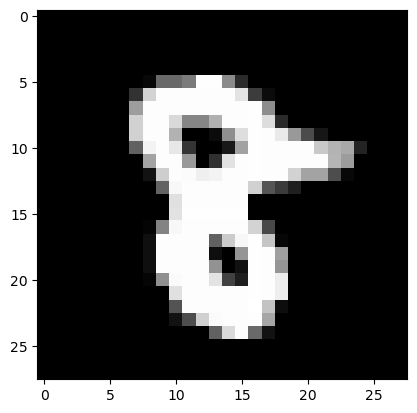

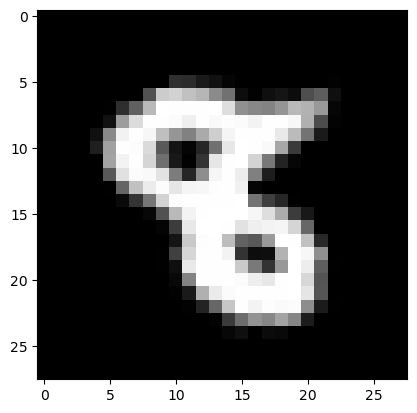

In [87]:
plt.imshow(train_X[2], cmap='gray')
plt.show()
plt.imshow(rotate(train_X[2],25), cmap='gray')
# print(train_X.shape)

After rotating, the the class of the image is still the same. Let us make a function to rotate multiple images by random angles. We want a slightly different image every time we run this function. So, we generate a random number between 0 and 1 and change it so that it lies between -constraint/2 and +constraint/2

In [88]:
def augRotate(sample, angleconstraint):
  if angleconstraint==0:
    return sample
  if len(sample.shape)==2:
    sample = np.expand_dims(sample, 0)  # make sure the sample is 3 dimensional
    # print(sample.shape)
  # print((sample))
  angle = rng.random(len(sample)) # generate random numbers for angles
  # print(angle)
  angle = (angle-0.5)*angleconstraint # make the random angle constrained
  # print(angle)
  nsample = sample.copy() # preallocate the augmented array to make it faster
  for ii in range(len(sample)):
    # print(sample[ii].shape)
    nsample[ii] = rotate(sample[ii], angle[ii])
  return np.squeeze(nsample) # take care if the input had only one sample.

This function returns a slightly different image each time we call it. So we can increase the number of images in the sample by any multiple.

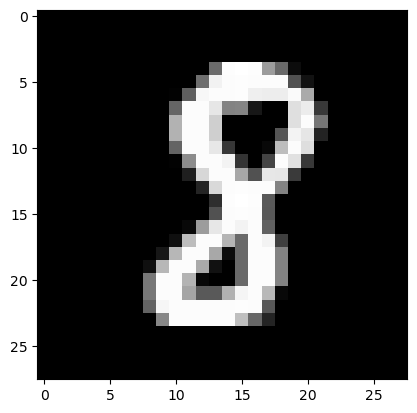

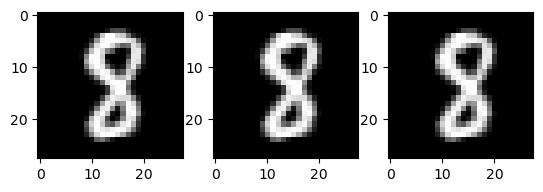

In [89]:
sample = train_X[20]
angleconstraint = 70
# show the original image
# print(len(sample.shape))
aug_sample = augRotate(sample, angleconstraint)
# print(aug_sample.shape)
plt.imshow(sample, cmap='gray')
plt.show()
plt.subplot(1,3,1)
plt.imshow(aug_sample, cmap='gray') # show an augmented image
plt.subplot(1,3,2)
plt.imshow(aug_sample, cmap='gray') # show another augmented image from the same sample
plt.subplot(1,3,3)
plt.imshow(aug_sample, cmap='gray') # one more image from the same sample

In [90]:
# hyperparameters
angleconstraint = 60
naugmentations = 5

# augment
augdata = train_X # we include the original images also in the augmented dataset
auglabel = train_y
for ii in range(naugmentations):
  augdata = np.concatenate((augdata, augRotate(train_X, angleconstraint))) # concatenate the augmented data to the set
  auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

# check the test accuracy
testpred = NN(augdata, auglabel, test_X)
print('Accuracy after rotation augmentation is ', Accuracy(test_y, testpred))

Accuracy after rotation augmentation is  0.6629


The angle constraint is a hyperparameter which we have to tune using a validation set. (Here we are not doing that for time constraints). Let us try a grid search to find the best angle constraint.

In [91]:
angleconstraints = [0,10,20,30,40,50,60,70,80,90] # the values we want to test
accuracies = np.zeros(len(angleconstraints), dtype=np.float64) # we will save the values here

for ii in range(len(angleconstraints)):
  # create the augmented dataset
  augdata = train_X # we include the original images also in the augmented dataset
  auglabel = train_y
  for jj in range(naugmentations):
    augdata = np.concatenate((augdata, augRotate(train_X, angleconstraints[ii]))) # concatenate the augmented data to the set
    auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

  # check the test accuracy
  testpred = NN(augdata, auglabel, test_X)
  accuracies[ii] = Accuracy(test_y, testpred)
  print('Accuracy after rotation augmentation constrained by ',angleconstraints[ii], ' is ', accuracies[ii], flush=True)

Accuracy after rotation augmentation constrained by  0  is  0.6472
Accuracy after rotation augmentation constrained by  10  is  0.6672
Accuracy after rotation augmentation constrained by  20  is  0.6733
Accuracy after rotation augmentation constrained by  30  is  0.684
Accuracy after rotation augmentation constrained by  40  is  0.6805
Accuracy after rotation augmentation constrained by  50  is  0.6706
Accuracy after rotation augmentation constrained by  60  is  0.667
Accuracy after rotation augmentation constrained by  70  is  0.6622
Accuracy after rotation augmentation constrained by  80  is  0.658
Accuracy after rotation augmentation constrained by  90  is  0.6458


Let us see the best value for angle constraint: (Ideally this should be done on validation set, not test set)

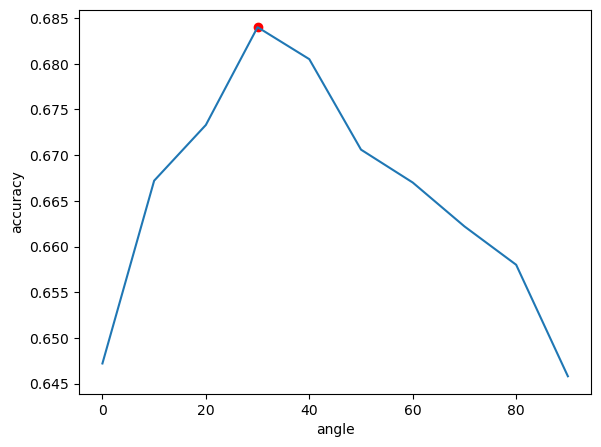

In [92]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
# plot the variation of accuracy
ax.plot(angleconstraints, accuracies)
ax.set_xlabel('angle')
ax.set_ylabel('accuracy')
# plot the maximum accuracy
maxind = np.argmax(accuracies)
plt.scatter(angleconstraints[maxind], accuracies[maxind], c='red')

Let us try one more augmentation: shear. Here is what this looks like:

In [93]:
def shear(sample, amount):
  tform = AffineTransform(shear = amount) # create the shear transform
  img = warp(sample, tform) # apply the shear
  # this makes the digit off-center. Since all the images in the test set are centralized, we will do the same here
  col = img.sum(0).nonzero()[0]
  row = img.sum(1).nonzero()[0]
  if len(col)>0 and len(row)>0:
    xshift = int(sample.shape[0]/2 - (row[0]+row[-1])/2)
    yshift = int(sample.shape[1]/2 - (col[0]+col[-1])/2)
    img = np.roll(img, (xshift, yshift),(0,1))
  return img

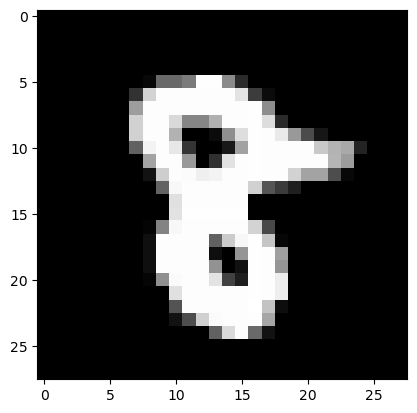

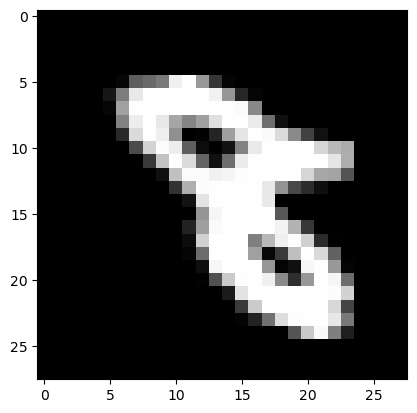

In [94]:
sample = train_X[2]
plt.imshow(sample, cmap='gray')
plt.show()

# apply shear
plt.imshow(shear(sample, 0.4), cmap='gray')

Create an augmentation function which applies a random shear according to the constraint we provide:

In [95]:
def augShear(sample, shearconstraint):
  if shearconstraint==0:
    return sample
  if len(sample.shape)==2:
    sample = np.expand_dims(sample, 0)  # make sure the sample is 3 dimensional
  amt = rng.random(len(sample)) # generate random numbers for shear
  amt = (amt-0.5)*shearconstraint # make the random shear constrained
  nsample = sample.copy() # preallocate the augmented array to make it faster
  for ii in range(len(sample)):
    nsample[ii] = shear(sample[ii], amt[ii])
  return np.squeeze(nsample) # take care if the input had only one sample.

Let us do a grid search to find the best shear constraint.

In [96]:
shearconstraints = [0, 0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0] # the values we want to test
accuracies = np.zeros(len(shearconstraints), dtype=np.float64) # we will save the values here

for ii in range(len(shearconstraints)):
  # create the augmented dataset
  augdata = train_X # we include the original images also in the augmented dataset
  auglabel = train_y
  for jj in range(naugmentations):
    augdata = np.concatenate((augdata, augShear(train_X, shearconstraints[ii]))) # concatenate the augmented data to the set
    auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

  # check the test accuracy
  testpred = NN(augdata, auglabel, test_X)
  accuracies[ii] = Accuracy(test_y, testpred)
  print('Accuracy after shear augmentation constrained by ',shearconstraints[ii], ' is ', accuracies[ii], flush=True)

Accuracy after shear augmentation constrained by  0  is  0.6472
Accuracy after shear augmentation constrained by  0.2  is  0.6347
Accuracy after shear augmentation constrained by  0.4  is  0.6491
Accuracy after shear augmentation constrained by  0.6  is  0.6601
Accuracy after shear augmentation constrained by  0.8  is  0.6586
Accuracy after shear augmentation constrained by  1.0  is  0.6533
Accuracy after shear augmentation constrained by  1.2  is  0.6487
Accuracy after shear augmentation constrained by  1.4  is  0.6475
Accuracy after shear augmentation constrained by  1.6  is  0.6415
Accuracy after shear augmentation constrained by  1.8  is  0.6374
Accuracy after shear augmentation constrained by  2.0  is  0.6155


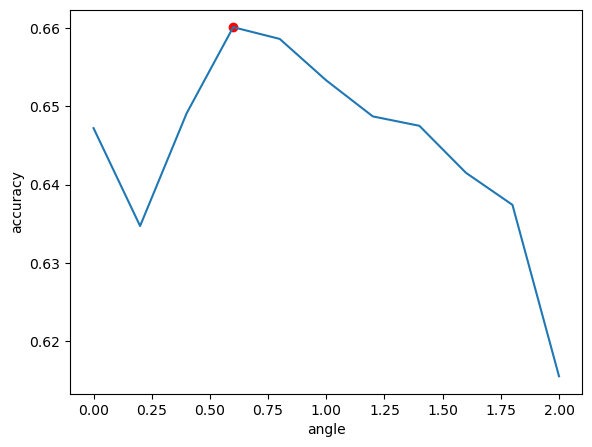

In [97]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
# plot the variation of accuracy
ax.plot(shearconstraints, accuracies)
ax.set_xlabel('angle')
ax.set_ylabel('accuracy')
# plot the maximum accuracy
maxind = np.argmax(accuracies)
plt.scatter(shearconstraints[maxind], accuracies[maxind], c='red')

We can do multiple augmentations at the same time. Here is a function to do both shear and rotation to the sample. In this case, we will have two hyperparameters.

In [98]:
def augRotateShear(sample, angleconstraint, shearconstraint):
  if len(sample.shape)==2:
    sample = np.expand_dims(sample, 0)  # make sure the sample is 3 dimensional
  amt = rng.random(len(sample)) # generate random numbers for shear
  amt = (amt-0.5)*shearconstraint # make the random shear constrained
  angle = rng.random(len(sample)) # generate random numbers for angles
  angle = (angle-0.5)*angleconstraint # make the random angle constrained
  nsample = sample.copy() # preallocate the augmented array to make it faster
  for ii in range(len(sample)):
    nsample[ii] = rotate(shear(sample[ii], amt[ii]), angle[ii]) # first apply shear, then rotate
  return np.squeeze(nsample) # take care if the input had only one sample.

Since we have two hyperparameters, we have to do the grid search on a 2 dimensional matrix. We can use our previous experience to inform where to search for the best hyperparameters.

In [99]:
shearconstraints = [0, 0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6] # the values we want to test
angleconstraints = [0,10,20,30,40,50,60] # the values we want to test
hyp = cartesian((shearconstraints, angleconstraints)) # cartesian product of both
# print(len(hyp))
accuracies = np.zeros(len(hyp), dtype=np.float64) # we will save the values here
# print(len(accuracies))
for ii in range(len(hyp)):
  # create the augmented dataset
  augdata = train_X # we include the original images also in the augmented dataset
  auglabel = train_y
  for jj in range(naugmentations):
    augdata = np.concatenate((augdata, augRotateShear(train_X, hyp[ii][0], hyp[ii][1]))) # concatenate the augmented data to the set
    auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

  # check the test accuracy
  testpred = NN(augdata, auglabel, test_X)
  accuracies[ii] = Accuracy(test_y, testpred)
  print('Accuracy after augmentation shear:',hyp[ii][0], 'angle:',hyp[ii][1], ' is ', accuracies[ii], flush=True)

Accuracy after augmentation shear: 0.0 angle: 0.0  is  0.6332
Accuracy after augmentation shear: 0.0 angle: 10.0  is  0.6379
Accuracy after augmentation shear: 0.0 angle: 20.0  is  0.6404
Accuracy after augmentation shear: 0.0 angle: 30.0  is  0.5876
Accuracy after augmentation shear: 0.0 angle: 40.0  is  0.617
Accuracy after augmentation shear: 0.0 angle: 50.0  is  0.6134
Accuracy after augmentation shear: 0.0 angle: 60.0  is  0.6251
Accuracy after augmentation shear: 0.2 angle: 0.0  is  0.6334
Accuracy after augmentation shear: 0.2 angle: 10.0  is  0.6281
Accuracy after augmentation shear: 0.2 angle: 20.0  is  0.5973
Accuracy after augmentation shear: 0.2 angle: 30.0  is  0.6036
Accuracy after augmentation shear: 0.2 angle: 40.0  is  0.6085
Accuracy after augmentation shear: 0.2 angle: 50.0  is  0.6194
Accuracy after augmentation shear: 0.2 angle: 60.0  is  0.6345
Accuracy after augmentation shear: 0.4 angle: 0.0  is  0.6344
Accuracy after augmentation shear: 0.4 angle: 10.0  is  0.5

Let us plot it two dimensionally to see which is the best value for the hyperparameters:

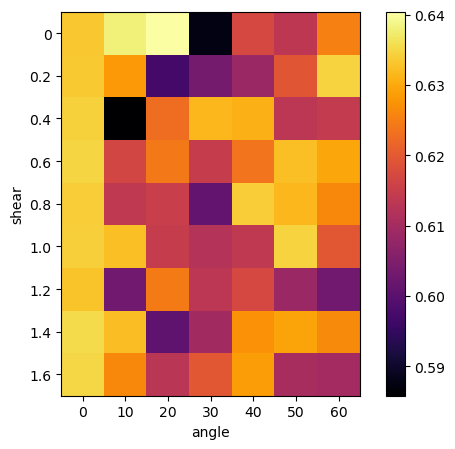

In [100]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
im = ax.imshow(accuracies.reshape((len(shearconstraints), len(angleconstraints))), cmap='inferno')
ax.set_xlabel('angle')
ax.set_ylabel('shear')
ax.set_xticks(np.arange(len(angleconstraints)));
ax.set_xticklabels(angleconstraints);
ax.set_yticks(np.arange(len(shearconstraints)));
ax.set_yticklabels(shearconstraints);
plt.colorbar(im)

It seems that rotation and shear don't mix! The best accuracy is when rotation is zero.

## Questions
Try these questions for better understanding. You may not be able to solve all of them.
1. What is the best value for angle constraint and shear constraint you got? How much did the accuracy improve as compared to not using augmentations?
2. Can you increase the accuracy by increasing the number of augmentations from each sample?
3. Try implementing a few augmentations of your own and experimenting with them. A good reference is <a href=https://www.analyticsvidhya.com/blog/2019/12/image-augmentation-deep-learning-pytorch/>here. </a>
4. Try combining various augmentations. What is the highest accuracy you can get? What is the smallest training dataset you can take and still get accuracy above 50%?

Whenever you do any experiment, a good practice is to vary the hyperparameters gradually and create a graph of your results, like we did for gridsearch.

1. A. The highest accuracy i got for both angle constrain and shear constrain was 0.6404 at an angle of 20.0 degrees and 0.0 shear tranformation. which dosent improve as compared to not using augmentation, The accuracy which i have got without using any argumentaion was 0.6472. And the accuracy that I've got for only rotaion was 0.684, which is way more better than the combined one and no-augumentaion one's.

In [101]:
# 2. A. Increasing the number of augmentations from each sample can sometimes improve the accuracy of the model, 
# but it's not a guaranteed and may have diminishing returns.

angleconstraints = [0,10,20,30,40,50,60,70,80,90] # the values we want to test

nargumentations = list(range(0, 51, 5))

for i in nargumentations:
  
  accuracies = np.zeros(len(angleconstraints), dtype=np.float64) # we will save the values here
  maxaccuracy = -1
  angle = 0
  for ii in range(len(angleconstraints)):
    # create the augmented dataset
    augdata = train_X # we include the original images also in the augmented dataset
    auglabel = train_y

    for jj in range(i):
      augdata = np.concatenate((augdata, augRotate(train_X, angleconstraints[ii]))) # concatenate the augmented data to the set
      auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

    # check the test accuracy
    testpred = NN(augdata, auglabel, test_X)
    accuracies[ii] = Accuracy(test_y, testpred)
    if (accuracies[ii] > maxaccuracy):
      maxaccuracy = accuracies[ii]
      angle  = angleconstraints[ii]
  print("Maximum accuracy at ", i, " number of argumets is ",maxaccuracy," at an angle ",angle)
    # print('Accuracy after rotation augmentation constrained by ',angleconstraints[ii], ' is ', accuracies[ii], flush=True)

Maximum accuracy at  0  number of argumets is  0.6472  at an angle  0
Maximum accuracy at  5  number of argumets is  0.6719  at an angle  50
Maximum accuracy at  10  number of argumets is  0.6899  at an angle  40
Maximum accuracy at  15  number of argumets is  0.6852  at an angle  30
Maximum accuracy at  20  number of argumets is  0.6873  at an angle  30
Maximum accuracy at  25  number of argumets is  0.6884  at an angle  30
Maximum accuracy at  30  number of argumets is  0.6879  at an angle  30
Maximum accuracy at  35  number of argumets is  0.6885  at an angle  30
Maximum accuracy at  40  number of argumets is  0.6866  at an angle  30
Maximum accuracy at  45  number of argumets is  0.6873  at an angle  30
Maximum accuracy at  50  number of argumets is  0.6883  at an angle  30


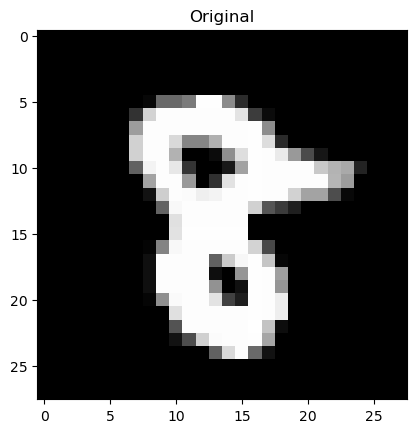

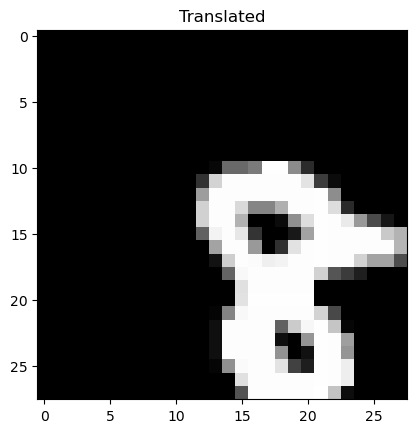

Accuracy of ( 0 , 0 ) shift is  0.6472
Accuracy of ( 0 , 1 ) shift is  0.6476
Accuracy of ( 0 , 2 ) shift is  0.6311
Accuracy of ( 0 , 3 ) shift is  0.6263
Accuracy of ( 0 , 4 ) shift is  0.6284
Accuracy of ( 0 , 5 ) shift is  0.6398
Accuracy of ( 1 , 0 ) shift is  0.6603
Accuracy of ( 1 , 1 ) shift is  0.6411
Accuracy of ( 1 , 2 ) shift is  0.6235
Accuracy of ( 1 , 3 ) shift is  0.622
Accuracy of ( 1 , 4 ) shift is  0.6302
Accuracy of ( 1 , 5 ) shift is  0.6386
Accuracy of ( 2 , 0 ) shift is  0.645
Accuracy of ( 2 , 1 ) shift is  0.6206
Accuracy of ( 2 , 2 ) shift is  0.6114
Accuracy of ( 2 , 3 ) shift is  0.6187
Accuracy of ( 2 , 4 ) shift is  0.6307
Accuracy of ( 2 , 5 ) shift is  0.6395
Accuracy of ( 3 , 0 ) shift is  0.6201
Accuracy of ( 3 , 1 ) shift is  0.6067
Accuracy of ( 3 , 2 ) shift is  0.6136
Accuracy of ( 3 , 3 ) shift is  0.6266
Accuracy of ( 3 , 4 ) shift is  0.6345
Accuracy of ( 3 , 5 ) shift is  0.6406
Accuracy of ( 4 , 0 ) shift is  0.617
Accuracy of ( 4 , 1 ) shift 

In [102]:
# 3. A. Another type of argumentaion technique i.e translation of images i.e 
# shifting the numbers in the xy plane

def translate_image(image, tx, ty):
    # Translate the image horizontally (tx) and vertically (ty)
    if(len(image.shape) == 2):
        image = np.expand_dims(image,0)
    translated_image = image.copy()
    for i in range(len(image)):
        translated_image[i] = np.roll(image[i], (tx, ty), axis=(0, 1))
        translated_image[i, :tx, :] = 0  # Fill the empty space with zeros
        translated_image[i, :, :ty] = 0
    return np.squeeze(translated_image)

original_image = train_X[2]
# print(original_image.shape)
translated_image = translate_image(original_image, tx=5, ty=5)
plt.imshow(original_image, cmap='gray')
plt.title("Original")
plt.show()
plt.imshow(translated_image, cmap='gray')
plt.title("Translated")
plt.show()


narguments = 5
accuracies = np.zeros((6,6), dtype=np.float64)
for x in range(0,6):
    for y in range(0,6):
        augdata = train_X
        auglabel = train_y
        for i in range(narguments):
            augdata = np.concatenate((augdata, translate_image(train_X, tx=x, ty=y)))
            auglabel = np.concatenate((auglabel, train_y))
        testpred = NN(augdata, auglabel, test_X)
        accuracies[x][y] = Accuracy(test_y, testpred)
        print("Accuracy of (",x,",",y,") shift is ", accuracies[x][y])




In [103]:
print("Accuracy Table for the Translation of the images is \n", accuracies)

Accuracy Table for the Translation of the images is 
 [[0.6472 0.6476 0.6311 0.6263 0.6284 0.6398]
 [0.6603 0.6411 0.6235 0.622  0.6302 0.6386]
 [0.645  0.6206 0.6114 0.6187 0.6307 0.6395]
 [0.6201 0.6067 0.6136 0.6266 0.6345 0.6406]
 [0.617  0.6121 0.6223 0.6309 0.6377 0.6411]
 [0.6191 0.6194 0.6277 0.633  0.6396 0.6419]]


In [104]:
# 4. A. Lets now take a smallest dataset i.e with only 25 images [ which covers all the classes ]
train_X = train_X[::2].copy()
train_Y = train_y[::2].copy()
print(train_X.shape)
print(train_Y.shape)

(25, 28, 28)
(25,)


In [105]:
print(train_Y)

[5 8 6 9 2 7 6 7 3 0 8 9 4 9 1 9 6 9 3 7 4 1 9 9 7]


In [106]:
testpred = NN(train_X, train_Y, test_X)
print('Baseline accuracy without augmentation is ', Accuracy(test_y, testpred))

Baseline accuracy without augmentation is  0.5717


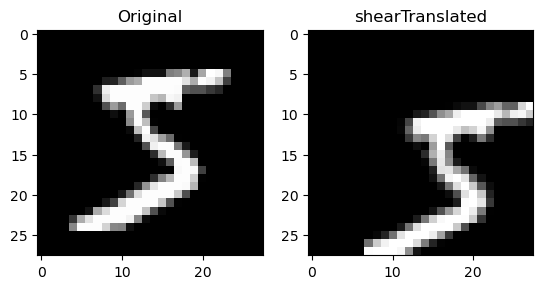

Text(0.5, 1.0, 'rotationTranslated')

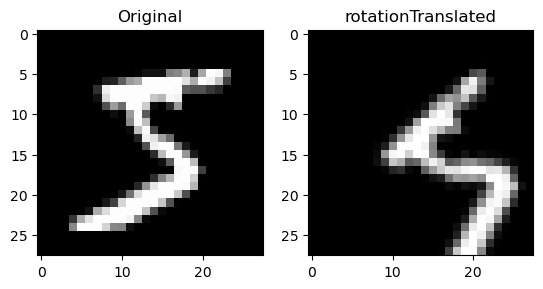

In [107]:

def shearTranslation(image, tx, ty, shearconstraint):
    image = augShear(image, shearconstraint)
    image = translate_image(image, tx, ty)
    return image

def rotationTranslation(image, tx, ty, angleconstraint):
    image = augRotate(image, angleconstraint)
    image = translate_image(image, tx, ty)
    return image

original_image = train_X[0]
# print(original_image.shape)
shearTranslated_image = shearTranslation(original_image, 4,4,1)
plt.subplot(1,2,1)
plt.imshow(original_image, cmap='gray')
plt.title("Original")
plt.subplot(1,2,2)
plt.imshow(shearTranslated_image, cmap='gray')
plt.title("shearTranslated")
plt.show()

rotationTranslated_image = rotationTranslation(original_image, 4,4, 70)
plt.subplot(1,2,1)
plt.imshow(original_image, cmap='gray')
plt.title("Original")
plt.subplot(1,2,2)
plt.imshow(rotationTranslated_image, cmap='gray')
plt.title("rotationTranslated")



In [108]:
narguments = 5

# angleconstraints = [0,10,20,30,40,50,60,70,80,90]
augdata = train_X
auglabel = train_Y
# c = 1
# for ii in range(len(angleconstraints)):
#   for jj in range(narguments):
#     augdata = np.concatenate((augdata, augRotate(train_X, angleconstraints[ii]))) # concatenate the augmented data to the set
#     # c += 1
#     auglabel = np.concatenate((auglabel, train_Y))  # the labels don't change when we augment

# print(augdata.shape, c)

for i in range(narguments):
    augdata = np.concatenate((augdata, augRotate(train_X, 30)))
    auglabel = np.concatenate((auglabel, train_Y))

train_X  = augdata
train_Y = auglabel


In [109]:
augdata = train_X
auglabel = train_Y

for x in range(0,6):
    for y in range(0,6):
        for i in range(narguments):
            augdata = np.concatenate((augdata, translate_image(train_X, tx=x, ty=y)))
            auglabel = np.concatenate((auglabel, train_Y))
train_X = augdata
train_Y = auglabel

In [110]:
print(train_X.shape)
print(train_Y.shape)

(27150, 28, 28)
(27150,)


In [111]:
testpred = NN(train_X, train_Y, test_X)
print('Accuracy after augmentation is ', Accuracy(test_y, testpred))

Accuracy after augmentation is  0.6241


The highest accuracy that i have obtained while taking a small dataset and augumenting its data items is 0.6241

In [112]:
#  Doubt : why the no  of train_X and no of train_Y is varying ?

# shearconstraints = [0, 0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6]
# angleconstraints = [0,10,20,30,40,50,60]
# print(len(hyp))
# augdata = train_X
# auglabel = train_y
# for ii in range(len(hyp)):
#   for jj in range(narguments):
#     augdata = np.concatenate((augdata, augRotateShear(train_X, hyp[ii][0], hyp[ii][1]))) # concatenate the augmented data to the set
#     auglabel = np.concatenate((auglabel, train_Y))  # the labels don't change when we augment

# train_X = augdata
# train_Y = auglabel